In [1]:
import numpy as np
import tensorflow as tf
import glob
import cv2
import matplotlib.pyplot as plt
import time
from IPython import display
import datetime

In [2]:
train_images = [cv2.imread(file) for file in glob.glob("archive/facades/train/*.jpg")]

In [3]:
train_images

[array([[[222, 207, 204],
         [225, 210, 207],
         [226, 213, 211],
         ...,
         [222,   0,   0],
         [222,   0,   0],
         [222,   0,   0]],
 
        [[223, 208, 205],
         [222, 207, 204],
         [222, 210, 206],
         ...,
         [222,   0,   0],
         [222,   0,   0],
         [222,   0,   0]],
 
        [[222, 208, 202],
         [220, 206, 200],
         [222, 210, 204],
         ...,
         [222,   0,   0],
         [222,   0,   0],
         [222,   0,   0]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [222,   0,   0],
         [222,   0,   0],
         [222,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  2,   0,   0],
         ...,
         [222,   0,   0],
         [222,   0,   0],
         [222,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  2,   0,   0],
         ...,
         [222,   0,   0],
  

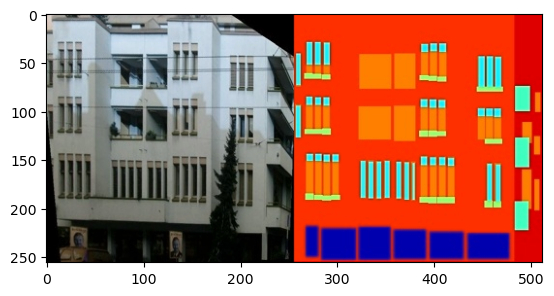

In [4]:
plt.imshow(train_images[0])

In [5]:
def load(image_file):
    
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors: real building and architecture image

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

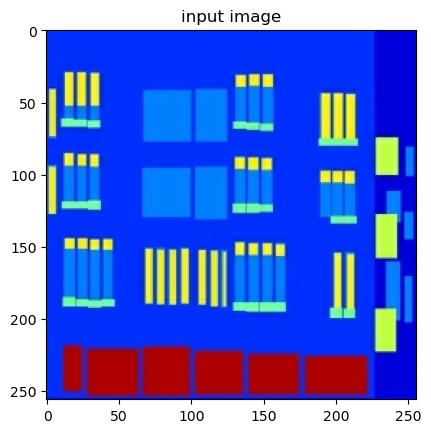

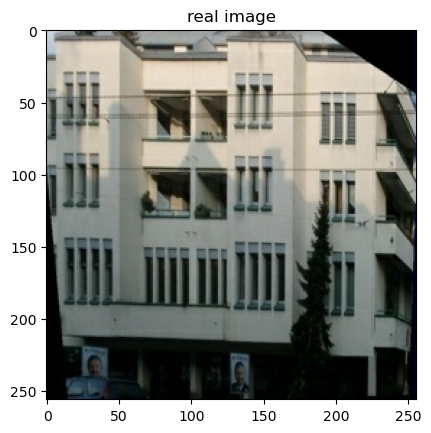

In [6]:
input_img, real_img = load("archive/facades/train/1.jpg")
plt.figure()
plt.title("input image")
plt.imshow(input_img/255.0)
plt.figure()
plt.title("real image")
plt.imshow(real_img/255.0)

In [7]:
def normalise(input_image, real_image):
    #normalising values between [-1, 1]
    
    input_image = (input_image - 127.5)/127.5
    real_image = (real_image - 127.5)/127.5
    return input_image, real_image

In [8]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = normalise(input_image, real_image)
    return input_image, real_image

In [9]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = normalise(input_image, real_image)
    return input_image, real_image

In [10]:
train_dataset = tf.data.Dataset.list_files('archive/facades/train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(400)
train_dataset = train_dataset.batch(1)
# research paper showed that batchsize=1 is the optimal situation for training this dataset

In [11]:
#upsampling function
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [12]:
#downsampling function
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [13]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
      ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
      ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer,activation='tanh')  
    # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


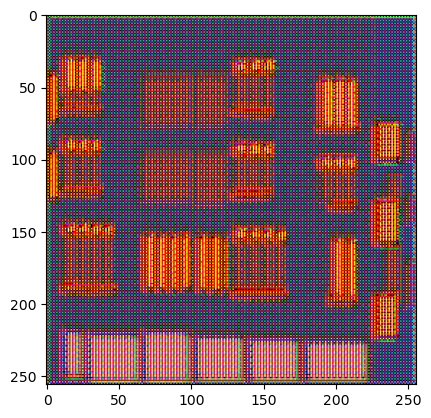

In [14]:
generator = Generator()
gen_output = generator(input_img[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [15]:
LAMBDA = 100

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # L1 loss function
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

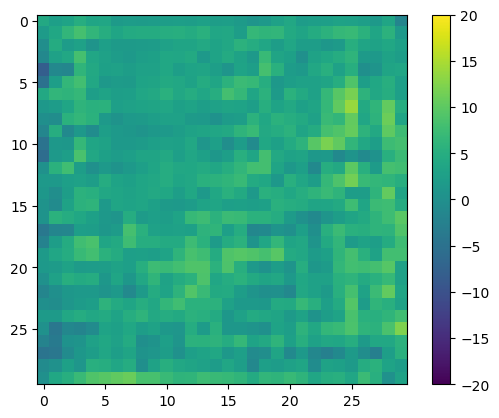

In [19]:
discriminator = Discriminator()
disc_output = discriminator([input_img[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_output[0, ..., -1], vmin=-20, vmax=20)
plt.colorbar()

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):

    # initialising loss variables
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [23]:
test_dataset = tf.data.Dataset.list_files('archive/facades/test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

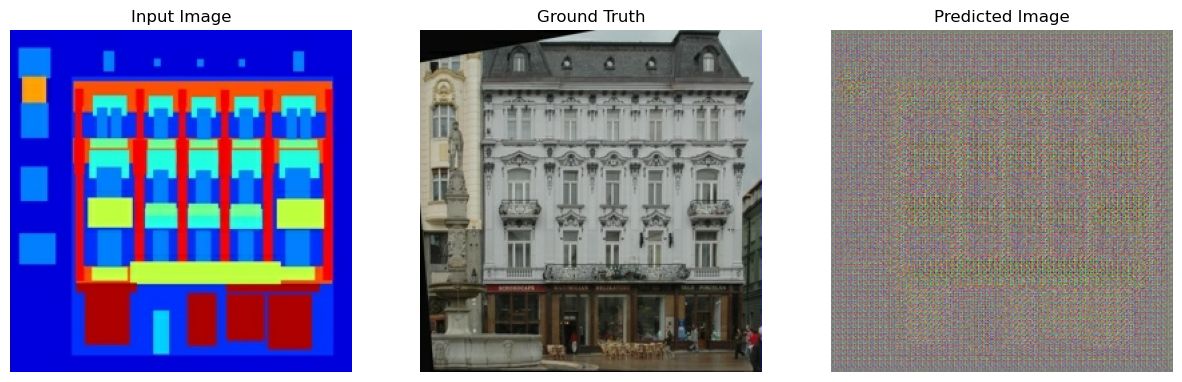

In [24]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [25]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [26]:
# train function step
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [27]:
# function for fitting
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}000")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print(f'{step+1} steps complete', flush=True)

Time taken for 1000 steps: 1714.79 sec



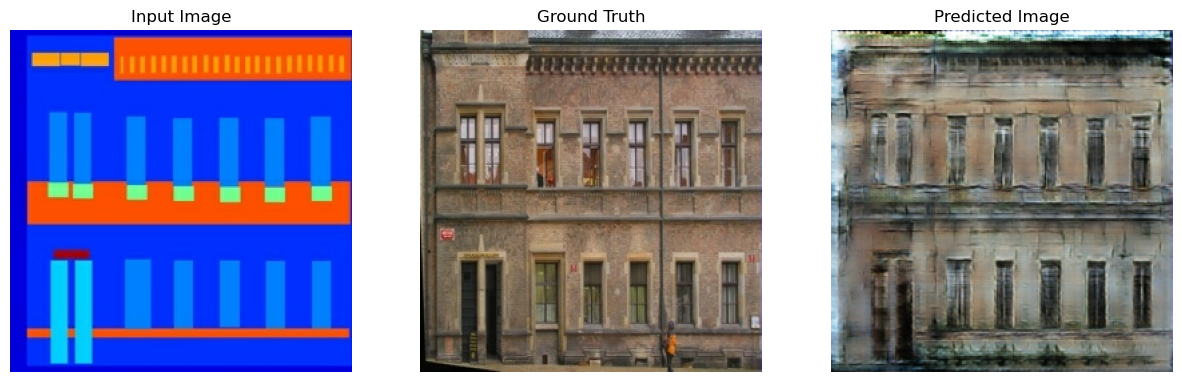

Step: 9000
9010 steps complete
9020 steps complete
9030 steps complete
9040 steps complete
9050 steps complete
9060 steps complete
9070 steps complete
9080 steps complete
9090 steps complete
9100 steps complete
9110 steps complete
9120 steps complete
9130 steps complete
9140 steps complete
9150 steps complete
9160 steps complete
9170 steps complete
9180 steps complete
9190 steps complete
9200 steps complete
9210 steps complete
9220 steps complete
9230 steps complete
9240 steps complete
9250 steps complete
9260 steps complete
9270 steps complete
9280 steps complete
9290 steps complete
9300 steps complete
9310 steps complete
9320 steps complete
9330 steps complete
9340 steps complete
9350 steps complete
9360 steps complete
9370 steps complete
9380 steps complete
9390 steps complete
9400 steps complete
9410 steps complete
9420 steps complete
9430 steps complete
9440 steps complete
9450 steps complete
9460 steps complete
9470 steps complete
9480 steps complete
9490 steps complete
9500 step

In [30]:
fit(train_dataset, test_dataset, steps=10000)

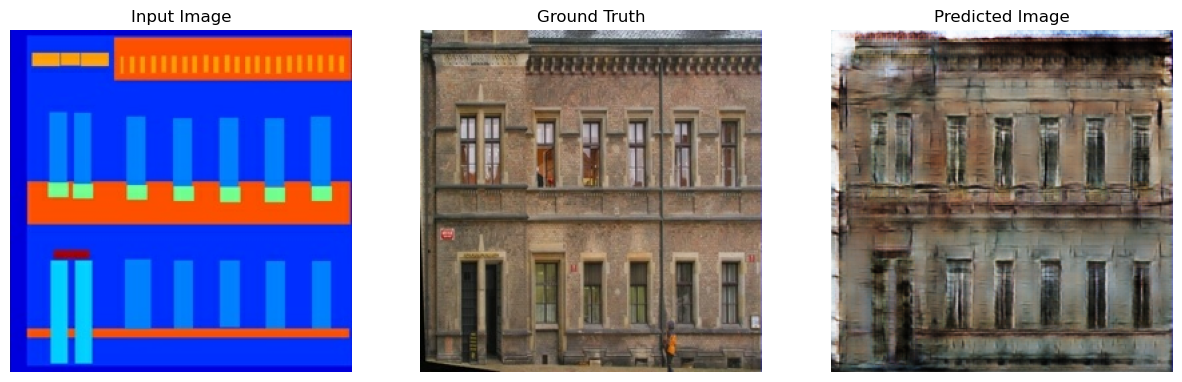

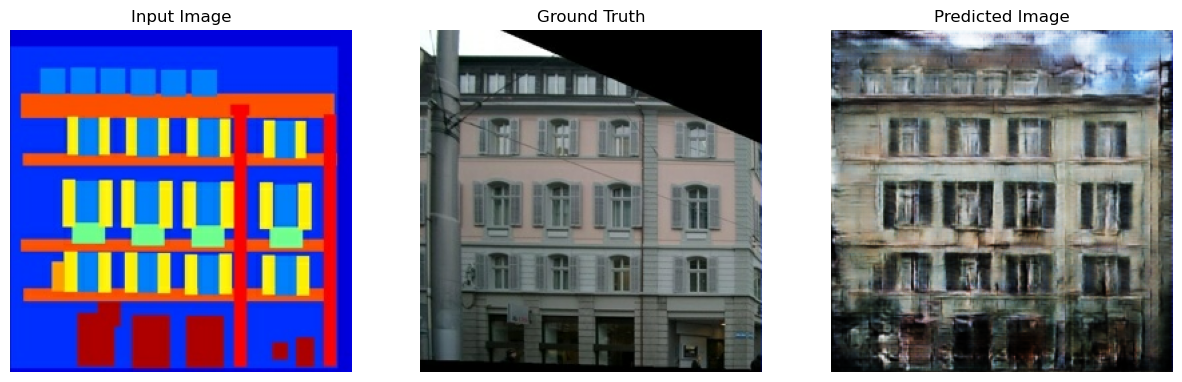

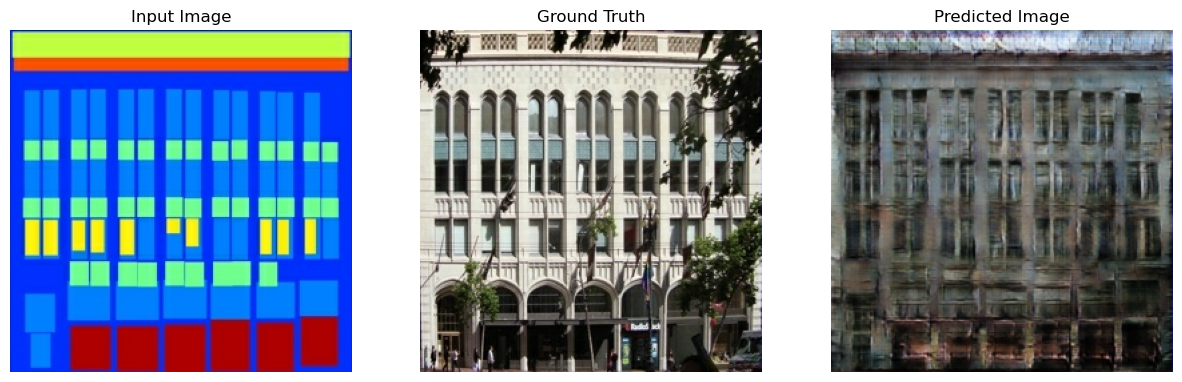

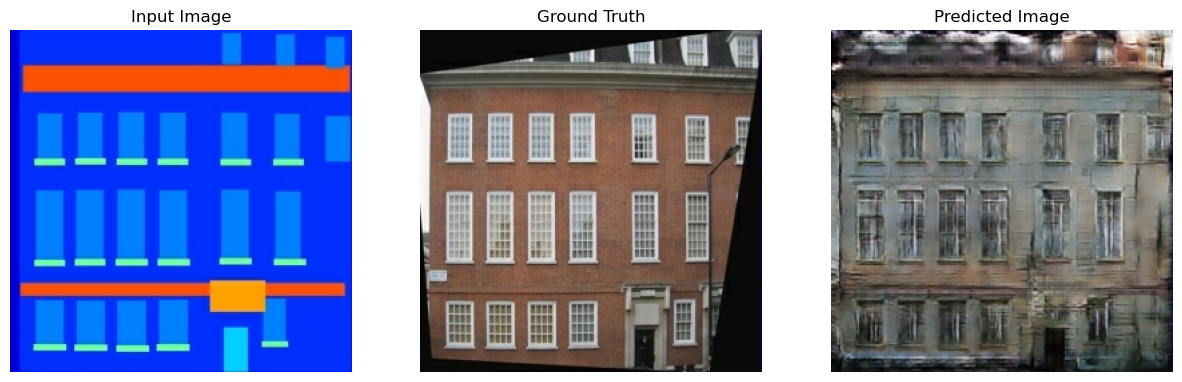

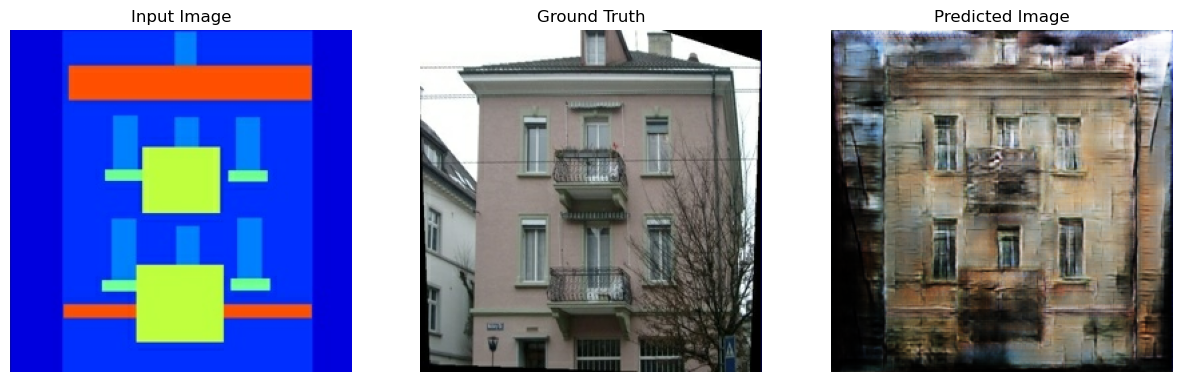

In [38]:
# displaying the generated images
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)